In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
from google.colab import drive
import zipfile

In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')
zip_path = '/content/gdrive/MyDrive/PR/lfw.zip'
output_path = '/content/lfw/'

os.makedirs(output_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_path)

print(f"Zip file '{zip_path}' has been successfully extracted to '{output_path}'.")



Mounted at /content/gdrive
Zip file '/content/gdrive/MyDrive/PR/lfw.zip' has been successfully extracted to '/content/lfw/'.


In [ ]:
path = "/content/lfw/lfw"


transform = transforms.Compose([
    transforms.ToTensor(),

])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

MPS device not found.


torch.Size([250, 250, 3])


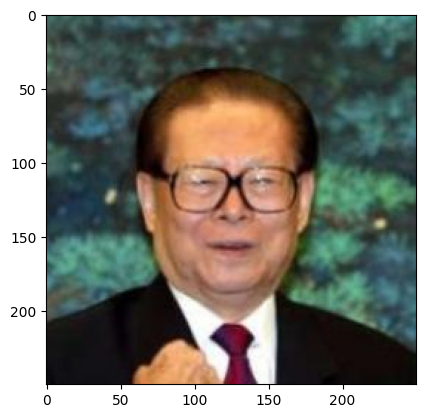

In [ ]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

In [ ]:
#In step 2, to describe the picture:  it means that suppose we have (250, 250 , 3)
#size of image it means that its height and width are 250 while its is a RGB color base as it has 3 channels

In [ ]:
import torch.nn.functional as F

class AE(nn.Module):

    def __init__(self):
        super(AE, self).__init__()
        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.enc_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)

        # Decoder Layers
        self.dec_upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.dec_upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.dec_upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.dec_upsample4 = nn.Upsample(size=(250, 250), mode='bilinear', align_corners=True)
        self.dec_conv4 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)

    def encoder(self, x):
        x = F.relu(self.enc_conv1(x))
        x = self.enc_pool1(x)
        x = F.relu(self.enc_conv2(x))
        x = self.enc_pool2(x)
        x = F.relu(self.enc_conv3(x))
        return x

    def decoder(self, x):
        x = self.dec_upsample1(x)
        x = F.relu(self.dec_conv1(x))
        x = self.dec_upsample2(x)
        x = F.relu(self.dec_conv2(x))
        x = self.dec_upsample3(x)
        x = F.relu(self.dec_conv3(x))
        x = self.dec_upsample4(x)
        x = torch.sigmoid(self.dec_conv4(x))  # Assuming the final output is a normalized image
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
from torchvision import transforms
from PIL import Image

model = AE()


transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load and preprocess an example image
image_path = "/content/lfw/lfw/AJ_Cook/AJ_Cook_0001.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # Add a batch dimension

# Forward pass through the model
output_tensor = model(input_tensor)

# Print the shapes of the encoder and decoder outputs
encoder_output_shape = model.encoder(input_tensor).shape
decoder_output_shape = output_tensor.shape

print("Encoder Output Shape:", encoder_output_shape)
print("Decoder Output Shape:", decoder_output_shape)


Encoder Output Shape: torch.Size([1, 128, 8, 8])
Decoder Output Shape: torch.Size([1, 3, 250, 250])


In [ ]:
#Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)

# Define a loss function (for example, Mean Squared Error)
loss_function = nn.MSELoss()

# Define an optimizer (for example, Adam optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Total number of trainable parameters: 190563


In [ ]:
from tqdm import tqdm  # For progress bar

# Function to train the AE model for one epoch
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0

    for inputs, _ in tqdm(dataloader, desc="Training", leave=False):

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, inputs)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / len(dataloader)
    return average_loss


# Create an instance of the AE model
model = AE()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Number of training epochs
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    # Train the model for one epoch
    train_loss = train_epoch(model, dataloader, loss_function , optimizer)

    # Print the average loss for the epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}')




Epoch [1/5], Training Loss: 0.0265


Epoch [2/5], Training Loss: 0.0165


Epoch [3/5], Training Loss: 0.0142


Epoch [4/5], Training Loss: 0.0130


Epoch [5/5], Training Loss: 0.0123


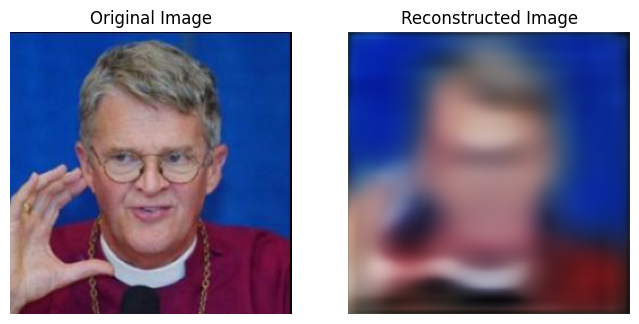

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Take a random image from the dataset
random_index = np.random.randint(len(dataloader.dataset))
sample_image, _ = dataloader.dataset[random_index]

# Forward pass through the model to get the reconstructed image
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    sample_image = sample_image.unsqueeze(0)  # Add batch dimension
    reconstructed_image = model(sample_image)

# Convert PyTorch tensors to numpy arrays for plotting
original_image_np = np.transpose(sample_image.squeeze().numpy(), (1, 2, 0))
reconstructed_image_np = np.transpose(reconstructed_image.squeeze().numpy(), (1, 2, 0))

# Plot the original and reconstructed images
plt.figure(figsize=(8, 4))

# Plot original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image_np)
plt.axis('off')

# Plot reconstructed image
plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.show()


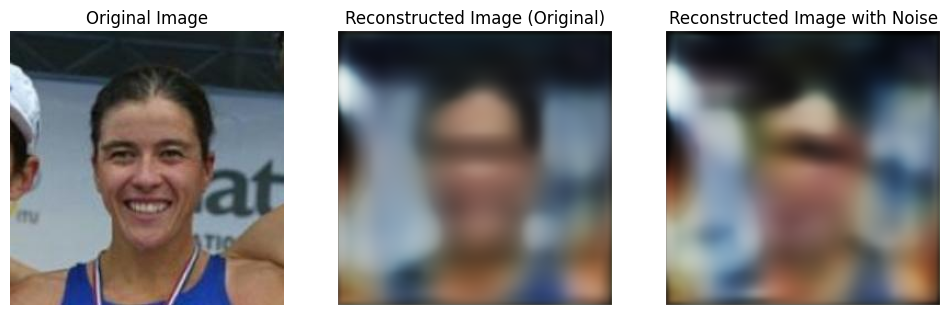

In [ ]:
# Function to add noise to latent representation and decode again
def add_noise_and_decode(model, image, noise_factor=0.1):
    # Set the model to evaluation mode
    model.eval()

    # Forward pass to get the latent representation
    with torch.no_grad():
        latent_representation = model.encoder(image)

    # Add Gaussian noise to the latent representation
    noisy_latent_representation = latent_representation + noise_factor * torch.randn_like(latent_representation)

    # Decode the noisy latent representation
    reconstructed_image = model.decoder(noisy_latent_representation)

    return reconstructed_image

# Take a random image from the dataset
random_index = np.random.randint(len(dataloader.dataset))
sample_image, _ = dataloader.dataset[random_index]

# Forward pass through the model to get the reconstructed image
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    sample_image = sample_image.unsqueeze(0)  # Add batch dimension

    # Original reconstruction
    reconstructed_image_original = model(sample_image)

    # Add noise to latent representation and decode again
    reconstructed_image_with_noise = add_noise_and_decode(model, sample_image, noise_factor=0.1)

# Plot the original, reconstructed, and reconstructed with noise images
def plot_images_with_noise(original, reconstructed_original, reconstructed_with_noise):
    original_image = np.transpose(original.squeeze().numpy(), (1, 2, 0))
    reconstructed_original_image = np.transpose(reconstructed_original.squeeze().numpy(), (1, 2, 0))
    reconstructed_with_noise_image = np.transpose(reconstructed_with_noise.squeeze().numpy(), (1, 2, 0))

    plt.figure(figsize=(12, 4))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')

    # Plot reconstructed image (original)
    plt.subplot(1, 3, 2)
    plt.title('Reconstructed Image (Original)')
    plt.imshow(reconstructed_original_image)
    plt.axis('off')

    # Plot reconstructed image with noise
    plt.subplot(1, 3, 3)
    plt.title('Reconstructed Image with Noise')
    plt.imshow(reconstructed_with_noise_image)
    plt.axis('off')

    plt.show()

# Plot the images
plot_images_with_noise(sample_image, reconstructed_image_original, reconstructed_image_with_noise)


In [ ]:
#An autoencoder's ability to withstand noisy input is improved and its capacity to adapt to variations in the real world is increased by introducing noise during training.
#It encourages the learning of more general features, which prevents overfitting by acting as regularisation.
#Noise injection is done on purpose in denoising autoencoders to help the model learn how to denoise for cleaner reconstructions.
#Finding a balance is important because too much noise can damage latent representations or impede learning.
#It is advised to experiment with different noise levels in accordance with particular data characteristics and modelling objectives.